In [1]:
import sys, os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patch
import cartopy.crs as ccrs

from typing import NamedTuple

from scipy.stats import pearsonr
from functools import partial

import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))

In [3]:
import constants

In [4]:
sys.path.append(constants.MODULE_DIR)

In [5]:
import stats
from importlib import reload

In [6]:
os.listdir(constants.LONGRUNMIP_DIR)

['tas',
 'surf',
 'netTOA',
 'sic_aso',
 'sic_fma',
 'zarr_test',
 'landesea_masks',
 'tos',
 'pr',
 '.ipynb_checkpoints',
 'psl',
 'sic']

In [7]:
os.listdir(os.path.join(constants.LONGRUNMIP_DIR, 'tos', 'regrid_retimestamped'))[:5]

['tos_ann_CCSM3_control_1530_g025.nc',
 'tos_ann_MPIESM11_control_2000_g025.nc',
 'tos_ann_MPIESM12_control_1500_g025.nc',
 'tos_ann_GFDLCM3_control_5200_g025.nc',
 'tos_ann_HadGEM2_abrupt4x_1295_g025.nc']

In [8]:
open_kwargs = dict(use_cftime=True)

In [9]:
abrupt_ds = xr.open_dataset(os.path.join(constants.LONGRUNMIP_DIR, 'tos', 'regrid_retimestamped', 'tos_ann_CESM104_abrupt4x_5900_g025.nc'), 
                           **open_kwargs).isel(time=slice(None, 1000))

In [130]:
control_ds = xr.open_dataset(os.path.join(constants.LONGRUNMIP_DIR, 'tos', 'regrid_retimestamped', 'tos_ann_CESM104_control_1000_g025.nc'),
                           **open_kwargs)

In [11]:
abrupt_ds

<xarray.Dataset>
Dimensions:  (time: 1000, lat: 72, lon: 144)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1000-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Data variables:
    tos      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Sun Jul 07 00:16:02 2019: cdo remapbil,mygrid tos_CESM104_a...
    NCO:          netCDF Operators version 4.7.6 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

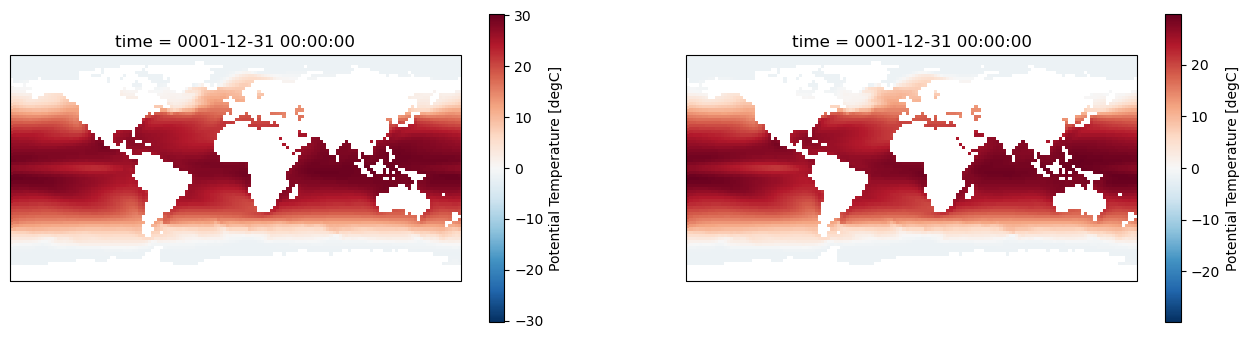

In [12]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

abrupt_ds.tos.isel(time=0).plot(ax=ax1)
contol_ds.tos.isel(time=0).plot(ax=ax2)

In [13]:
class Nino34(NamedTuple):
    lat1 = -5
    lat2 = 5
    lon1 = 190
    lon2  = 240

In [127]:
nino34_bounds = dict(lat=slice(-5, 5), lon=slice(190, 240))

In [15]:
def nino34_index(sst:xr.DataArray, climatology_da:xr.DataArray=None) ->  xr.DataArray:
    """
    Calculate the NINO3.4 index.

    Args:
        sst (xarray.DataArray): Sea surface temperature data.

    Returns:
        xarray.DataArray: NINO3.4 index.
    """
    #nino34_bounds = dict(lat=slice(-5, 5), lon=slice(190, 240))
    # Define the NINO3.4 nino34_bounds
    nino34_region = sst.sel(**nino34_bounds)  # May need to alter this depending on the dataset
    
    # Calculate the climatology
    if climatology_da is None:
        climatology = nino34_region.mean()
    else:
        climatology = climatology_da.sel(**nino34_bounds).mean()
        
    # Calculate the monthly anomalies
    anomalies = (nino34_region - climatology).mean(dim=['lat', 'lon'])
    # Calculate the rolling mean of the monthly anomalies
    anomalies_rolling = anomalies.rolling(time=5).mean()
    # Calculate the standard deviation of the NINO3.4 region
    sst_std = nino34_region.std()
    # Calculate the NINO3.4 index
    nino34_index = anomalies_rolling / sst_std

    return nino34_index

In [105]:
abrupt_trend_ds = stats.trend_fit(abrupt_ds, method='polynomial', order=11)
abrupt_detrend_ds = abrupt_ds - abrupt_trend_ds

In [116]:
abrupt_nino_ds = nino34_index(abrupt_detrend_ds)

In [132]:
control_nino_ds = nino34_index(control_ds)

In [133]:
abupt_nino_temps_ds = abrupt_ds.sel(**nino34_bounds).mean(dim=['lat', 'lon'])
control_nino_temps_ds = control_ds.sel(**nino34_bounds).mean(dim=['lat', 'lon'])
abupt_nino_temps_ds

<xarray.Dataset>
Dimensions:  (time: 1000)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1000-12-31 00:00:00
Data variables:
    tos      (time) float32 25.67 25.72 26.22 26.34 ... 32.17 31.97 29.1 29.47

In [134]:
abupt_nino_temps_trend_ds = stats.trend_fit(abupt_nino_temps_ds.dropna(dim='time'), method='polynomial', order=11)
abupt_nino_temps_detrend_ds = abupt_nino_temps_ds - abupt_nino_temps_trend_ds

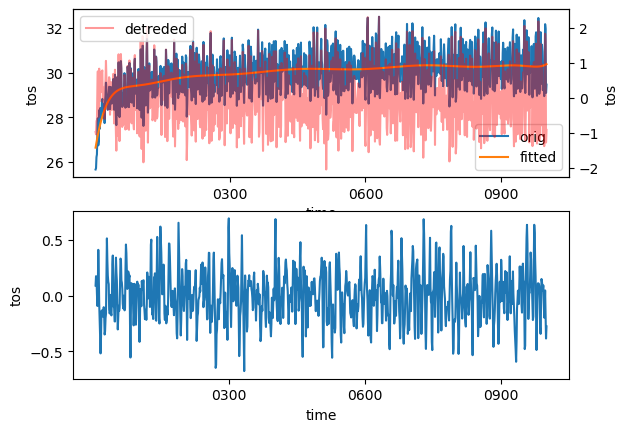

In [135]:
fig, axes = plt.subplots(2)
abupt_nino_temps_ds.tos.plot(ax=axes[0], label='orig')
abupt_nino_temps_trend_ds.tos.plot(ax=axes[0], label='fitted')
ax0_twinx = axes[0].twinx()
abupt_nino_temps_detrend_ds.tos.plot(ax=ax0_twinx, color='red', alpha=0.4, label='detreded')
axes[0].legend(); ax0_twinx.legend()
contol_nino_ds.tos.plot(ax=axes[1])

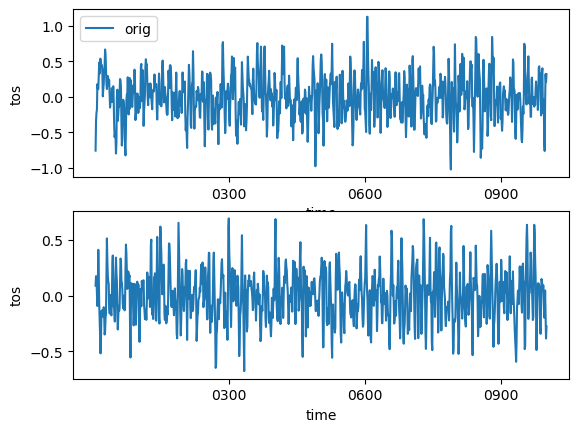

In [119]:
fig, axes = plt.subplots(2)
abrupt_nino_ds.tos.plot(ax=axes[0], label='orig')
# abrupt_niano_trend_ds.tos.plot(ax=axe`s[0], label='fitted')
# ax0_twinx = axes[0].twinx()
# abrupt_nino_detrend_ds.tos.plot(ax=ax0_twinx, color='red', alpha=0.4, label='detreded')
axes[0].legend(); ax0_twinx.legend()
contol_nino_ds.tos.plot(ax=axes[1])

In [20]:
def pearsonr_nonnan(x, y):
    """
    Calculate Pearson correlation coefficient between two arrays with non-NaN values.

    Args:
        x (array-like): First input array.
        y (array-like): Second input array.

    Returns:
        float: Pearson correlation coefficient.
    """
    id_ = np.isfinite(x) & np.isfinite(y)
    x = x[id_]
    y = y[id_]
    if len(x) < 5 or len(y) < 5:
        return np.nan
    return pearsonr(x, y)[0]

def correlate_nino(da: xr.DataArray, nino_da: xr.DataArray) -> xr.DataArray:
    """
    Calculate Pearson correlation coefficients between a DataArray and NINO DataArray.

    Args:
        da (xarray.DataArray): DataArray to correlate with NINO.
        nino_da (xarray.DataArray): NINO DataArray.

    Returns:
        xarray.DataArray: Array of correlation coefficients.
    """
    # Drop NaN values from NINO DataArray
    nino_da = nino_da.dropna(dim='time')
    # Only keep the overlapping time values between da and nino_da
    da = da.copy().where(da.time.isin(nino_da.time.values), drop=True)
    # Create a partial function with fixed 'y' argument for pearsonr_nonnan
    nino_pearsonr = partial(pearsonr_nonnan, y=nino_da.values)
    # Apply the nino_pearsonr function along the 'time' axis of da
    corr_values = np.apply_along_axis(nino_pearsonr, da.get_axis_num('time'), da.values)
    # Get the coordinates from the first time index of da and drop the 'time' coordinate
    coords = da.isel(time=0).drop('time').coords
    # Create a new DataArray with correlation values and coordinates
    return xr.DataArray(corr_values, coords)

In [21]:
control_corr_da = correlate_nino(contol_ds.tos, contol_nino_ds.tos)

In [120]:
abrupt_corr_da = correlate_nino(abrupt_detrend_ds.tos, abrupt_nino_ds.tos)

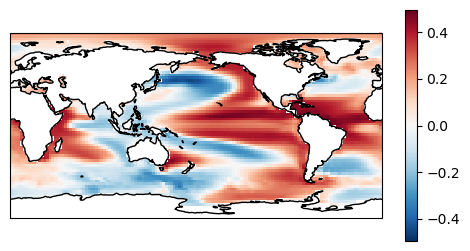

In [121]:
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='110m')
abrupt_corr_da.plot(ax=ax, transform=ccrs.PlateCarree())

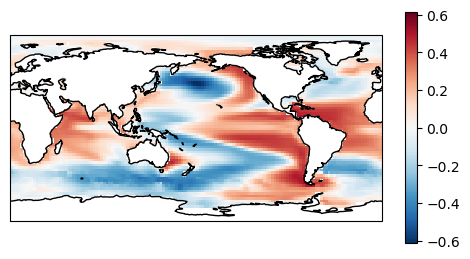

In [122]:
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='110m')

control_corr_da.plot(ax=ax, transform=ccrs.PlateCarree())

In [123]:
sys.path.append(constants.MODULE_DIR)

import signal_to_noise as sn

sn.multiwindow_signal_to_nosie_and_bounds

<function signal_to_noise.multiwindow_signal_to_nosie_and_bounds(experiment_da: xarray.core.dataarray.DataArray, control_da: xarray.core.dataarray.DataArray, da_for_noise: Optional[xarray.core.dataarray.DataArray] = None, rolling_noise=True, time_slice: Tuple[int] = None, windows: Optional[Tuple[int]] = None, start_window: int = 21, end_window: Optional[int] = None, step_window: Optional[int] = None, detrend: bool = True, detrend_kwargs: Optional[Dict] = {}, parallel=False, logginglevel='INFO', return_all=False, return_control: bool = False) -> xarray.core.dataset.Dataset>

In [138]:
nino_stabbility_ds = sn_multi_static_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    abupt_nino_temps_ds.tos, control_nino_temps_ds.tos,
    rolling_noise=True, detrend=True, detrend_kwargs = dict(method='polynomial', order=16),
    logginglevel='ERROR', return_all=True, windows=[21, 41, 61, 81])


Experiment
--------
21, 41, 61, 81, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

21, 41, 61, 81, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge


In [139]:
nino_stabbility_ds

<xarray.Dataset>
Dimensions:          (time: 1000, window: 4)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 1000-12-31 00:00:00
  * window           (window) int64 21 41 61 81
Data variables:
    signal           (window, time) float64 2.701 2.411 2.122 ... nan nan nan
    da_for_noise     (window, time) float64 -0.1576 -0.389 ... -1.067 -0.6558
    noise            (window, time) float64 0.4461 0.445 0.4389 ... nan nan nan
    signal_to_noise  (window, time) float64 6.056 5.418 4.835 ... nan nan nan
    lower_bound      (window) float64 -1.081 -0.7 -0.4612 -0.3266
    upper_bound      (window) float64 1.222 0.7072 0.5412 0.4081

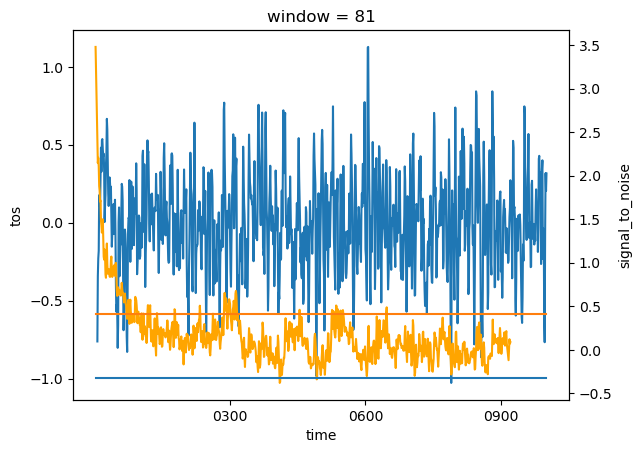

In [140]:
fig = plt.figure()
ax = plt.axes()
abrupt_nino_ds.tos.plot(ax=ax)
ax2 = ax.twinx()
nino_stabbility_ds_subset = nino_stabbility_ds.sel(window=81)
nino_stabbility_ds_subset.signal_to_noise.plot(ax=ax2, color='orange')
ax2.plot(nino_stabbility_ds_subset.time.values, [nino_stabbility_ds_subset.lower_bound.values]*len(nino_stabbility_ds.time.values))
ax2.plot(nino_stabbility_ds_subset.time.values, [nino_stabbility_ds_subset.upper_bound.values]*len(nino_stabbility_ds.time.values))